<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/cv/faces-cnn-export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning approach to facial emotion detection

## Getting and preprocessing faces data

* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.kaggle.com/datasets/msambare/fer2013
* https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
  * https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.21.6'

In [3]:
import pandas as pd
pd.__version__

'1.3.5'

In [4]:
from google.colab import drive
import sys

if 'google.colab' in sys.modules:
  drive.mount("/content/drive")
  !cp /content/drive/MyDrive/public/data/fer2013.tar.gz .
  !tar -xzvf fer2013.tar.gz
  FER2013_CSV_PATH = "./fer2013/fer2013.csv"
else:
  FER2013_CSV_PATH = "/home/olli/cv/fer2013/fer2013.csv"

Mounted at /content/drive
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [5]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [7]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

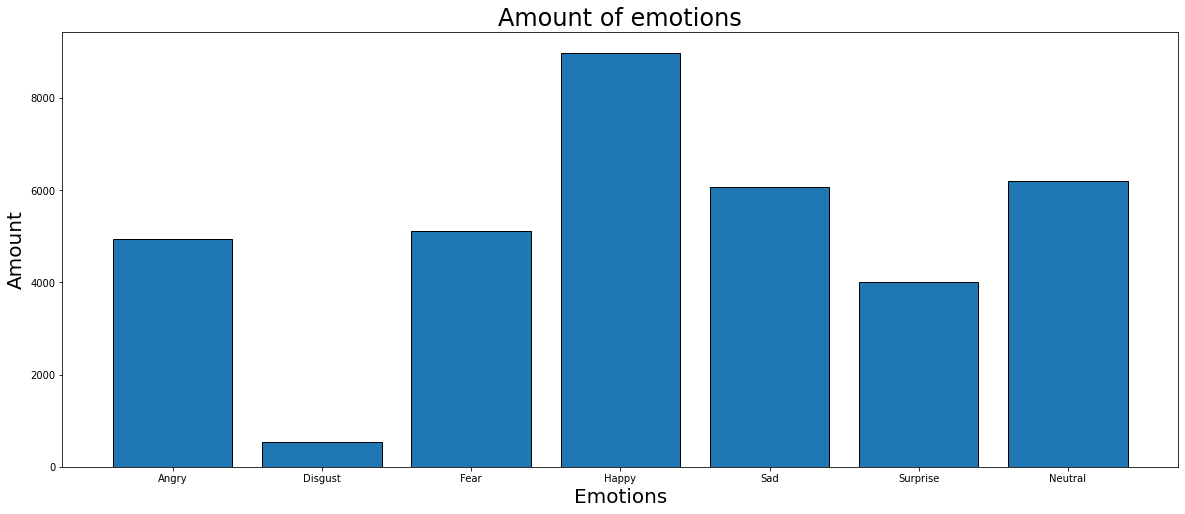

In [9]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [10]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])] 

In [11]:
# now some labels just don't have a samples, we shift all lables to the left

filtered_df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [12]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [13]:
# pandas again makes this impossible to get right without stack overflow
# this does work even though we can an error
filtered_df.loc[filtered_df["emotion"] == 3, "emotion"] = 1
filtered_df.loc[filtered_df["emotion"] == 4, "emotion"] = 2
filtered_df.loc[filtered_df["emotion"] == 5, "emotion"] = 3
filtered_df.loc[filtered_df["emotion"] == 6, "emotion"] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
filtered_df["emotion"].value_counts()

1    8989
4    6198
2    6077
0    4953
3    4002
Name: emotion, dtype: int64

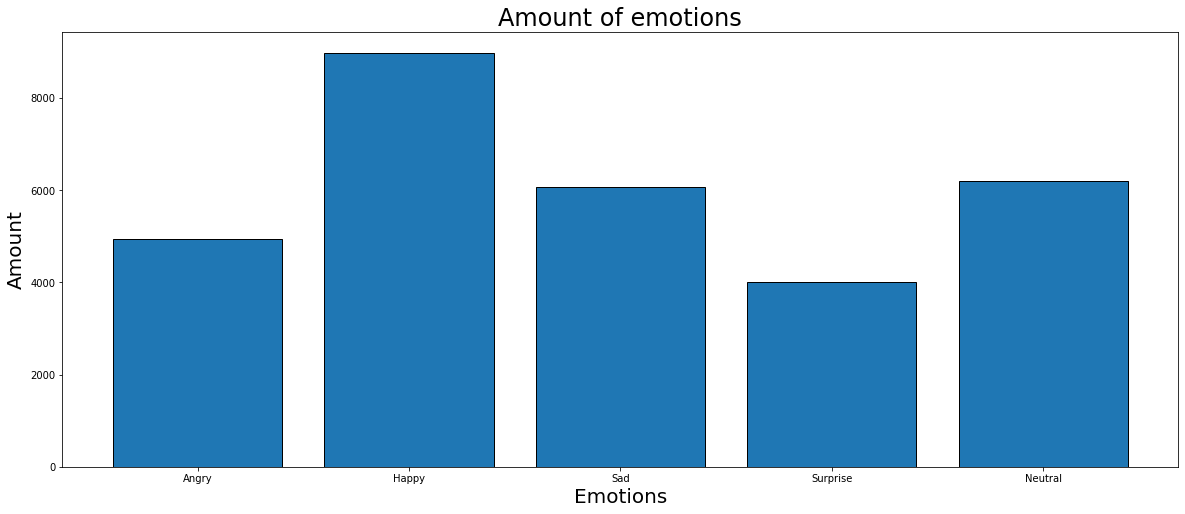

In [15]:
plot_data(filtered_df, filtered_label_names)

In [16]:
df = filtered_df

In [17]:
pixels = df["pixels"]
len(pixels)

30219

In [18]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'float64'), resolution)
    return image

In [19]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape

CPU times: user 7.91 s, sys: 460 ms, total: 8.37 s
Wall time: 8.37 s


(30219, 48, 48)

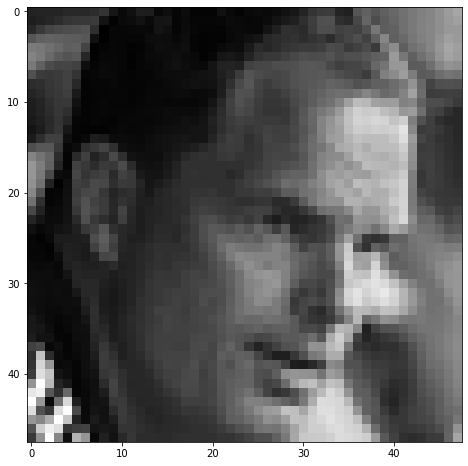

In [20]:
plt.imshow(images[100], cmap='gray');

In [21]:
labels = df["emotion"].values

In [22]:
labels.shape

(30219,)

In [23]:
X = images
y = labels

In [24]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

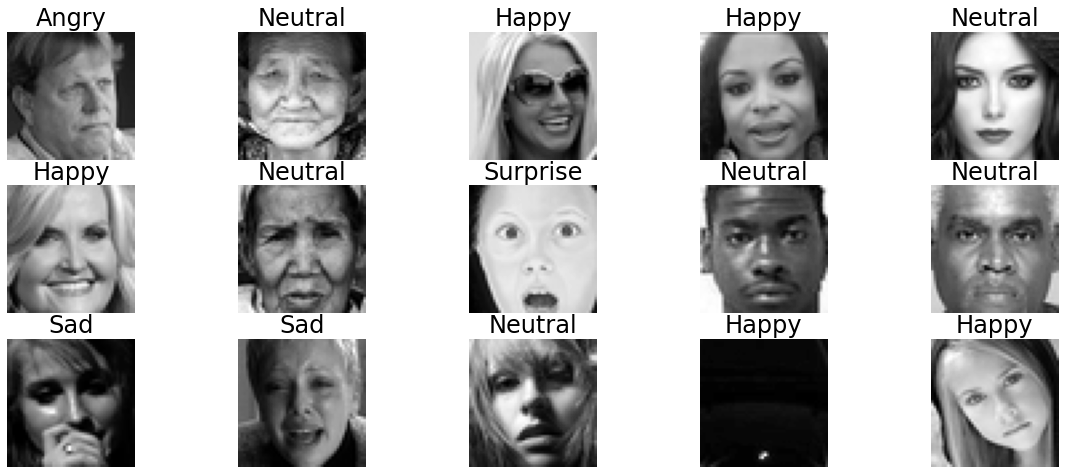

In [25]:
plot_gallery(X, y, filtered_label_names)

## Preparing Training

In [26]:
images.shape, images.dtype

((30219, 48, 48), dtype('float64'))

In [27]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255.0, 0.0)

In [28]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [29]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

In [30]:
# our default tools are still flexible enough to work with this
# (or not as the version of matplotlib running on colab)

# plot_gallery(images_normlized, y, label_names)

In [31]:
input_shape=(48, 48, 1)

In [32]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [33]:
num_classes = labels.max() + 1
num_classes

5

## What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?

In [34]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [35]:
!nvidia-smi

Wed Oct 26 14:28:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
# ResNet50?

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# model = ResNet50(weights='imagenet')
model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

In [39]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

0

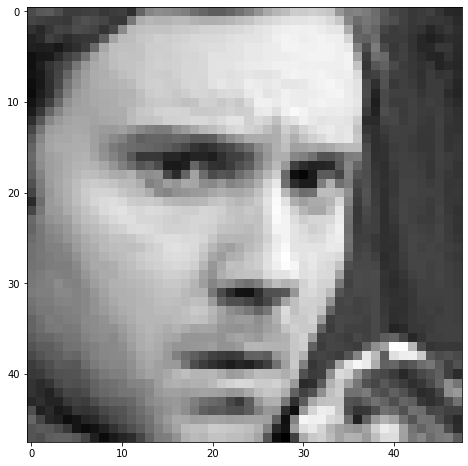

In [41]:
# labels: "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
img = images[0]
plt.imshow(img, cmap='gray');
labels[0]

In [42]:
# From docs: The images are converted from RGB to BGR, then each color channel is 
# zero-centered with respect to the ImageNet dataset, without scaling.

# preprocess_input?

In [43]:
# this is what ImageNet dataset looks like, but for the rest of the world this is just weird
# so let's not do this
x = preprocess_input(img.copy())
x.shape, x.dtype, x.min(), x.max()

((48, 48), dtype('float64'), -84.68, 210.0)

In [44]:
X = images_normlized
y = labels

In [45]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24175, 48, 48, 1), (6044, 48, 48, 1), (24175,), (6044,))

In [46]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [47]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

     |████████████████████████████████| 71 kB 4.8 MB/s 
     |████████████████████████████████| 1.6 MB 28.3 MB/s 


In [48]:
%%time

from lrcurve import KerasLearningCurve

BATCH_SIZE = 50
# EPOCHS = 500
EPOCHS = 75
# EPOCHS = 5

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 2min 57s, sys: 13.9 s, total: 3min 11s
Wall time: 2min 40s


## Evaluating results

In [49]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.7748463153839111, 0.71007239818573)

In [50]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.9500946402549744, 0.6326935887336731)

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None, label_names=label_names):
    y_pred = model.predict(X, batch_size=BATCH_SIZE).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [52]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [53]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

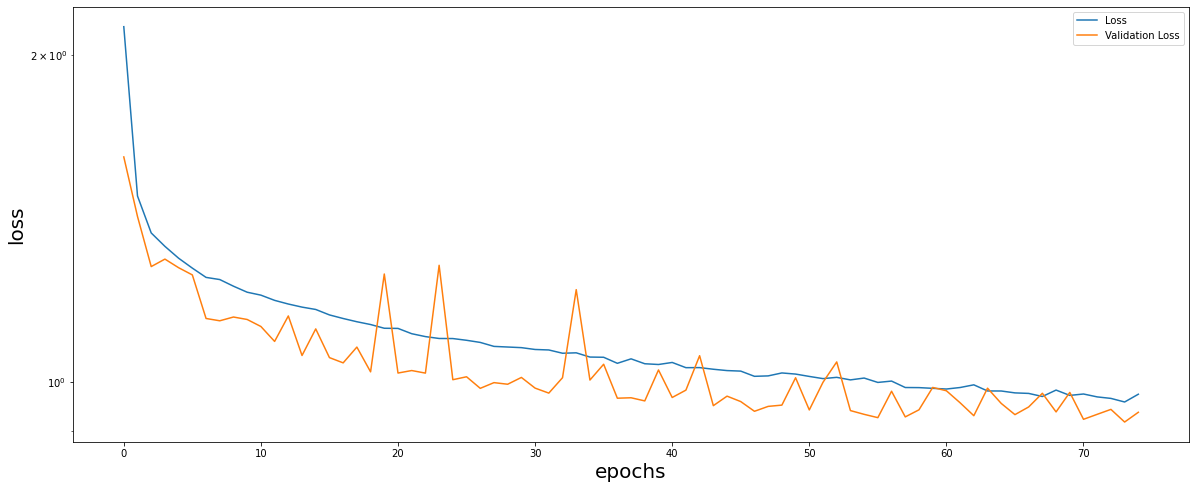

In [54]:
plot_loss(history)

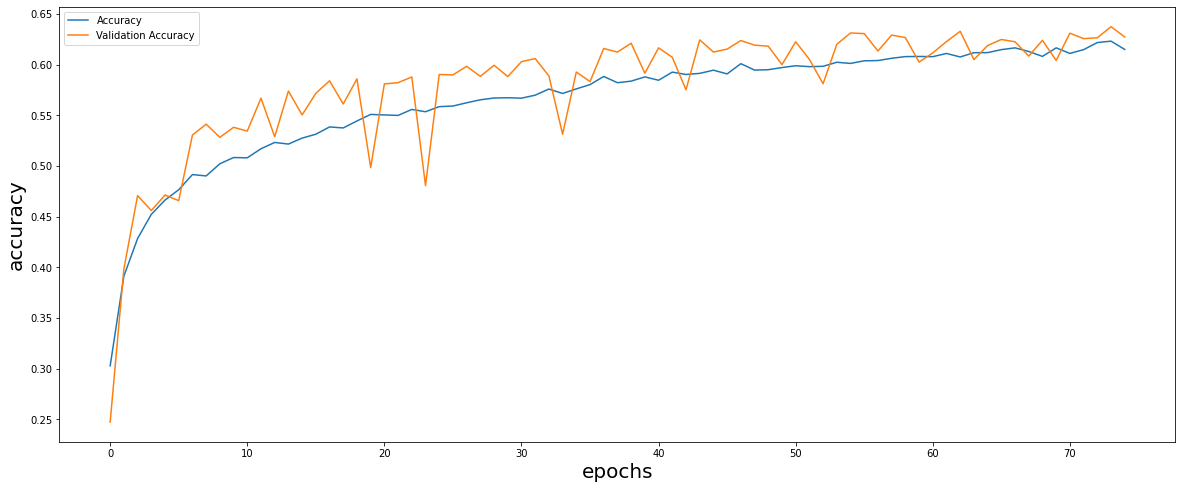

In [55]:
plot_accuracy(history)

484/484 [==============================] - 3s 6ms/step


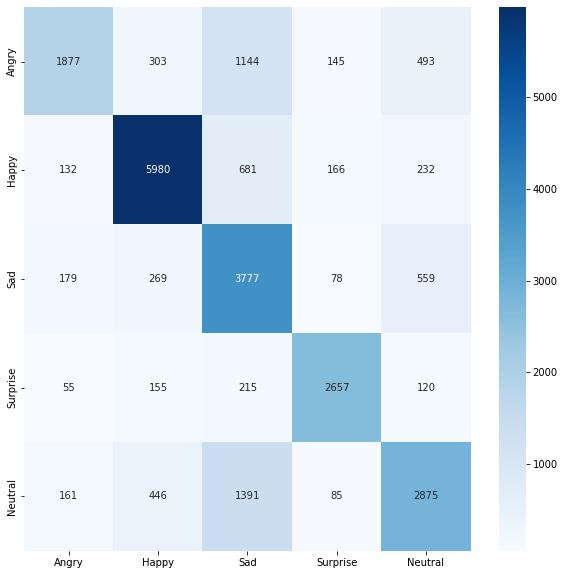

In [58]:
plot_cm(model, X_train, y_train, label_names=filtered_label_names)

## Saving model

In [ ]:
if 'google.colab' in sys.modules:
  !pip install tensorflowjs


In [ ]:
import tensorflowjs as tfjs

In [61]:
model.save('simple-vgg.h5')

In [62]:
!ls -l

total 113712
drwx------ 6 root   root     4096 Oct 26 14:27 drive
drwxr-x--- 2 204241 5762     4096 Jul 10  2013 fer2013
-rw------- 1 root   root 96433867 Oct 26 14:27 fer2013.tar.gz
drwxr-xr-x 1 root   root     4096 Oct 24 13:33 sample_data
-rw-r--r-- 1 root   root 19990344 Oct 26 14:39 simple-vgg.h5
